In [22]:
import pandas as pd
from pandas import DataFrame
import os
import json

prefix_old: str = 'old'
prefix_new: str = 'new'
data_folder: str = '../../data/processed'
all_new_data_files: list = [file_name for file_name in os.listdir(data_folder) if prefix_new in file_name and not 'all_' in file_name]
all_old_data_files: list = [file_name for file_name in os.listdir(data_folder) if prefix_old in file_name and not 'all_' in file_name]
all_data_files: list = os.listdir(data_folder)

In [29]:
all_new_data_files

['wordle_withcritic_new_processed.jsonl',
 'referencegame_new_processed.jsonl',
 'taboo_new_processed.jsonl',
 'imagegame_new_processed.jsonl',
 'privateshared_new_processed.jsonl',
 'wordle_withclue_new_processed.jsonl',
 'wordle_new_processed.jsonl']

In [24]:
# The list of the top 10 models from benchmark version 0.9-1.0
top_10_models: list = [
    'gpt-4-0613-t0.0--gpt-4-0613-t0.0',
    'claude-v1.3-t0.0--claude-v1.3-t0.0',
    'gpt-4-1106-preview-t0.0--gpt-4-1106-preview-t0.0',
    'gpt-4-t0.0--gpt-4-t0.0',
    'gpt-4-0314-t0.0--gpt-4-0314-t0.0',
    'claude-2.1-t0.0--claude-2.1-t0.0',
    'gpt-4-t0.0--gpt-3.5-turbo-t0.0',
    'claude-2-t0.0--claude-2-t0.0',
    'gpt-3.5-turbo-1106-t0.0--gpt-3.5-turbo-1106-t0.0',
    'gpt-3.5-turbo-0613-t0.0--gpt-3.5-turbo-0613-t0.0',   
]

In [30]:
data_old: DataFrame = None

for data_file in all_new_data_files:
    df: DataFrame = pd.read_json(data_folder + f'/{data_file}', lines=True)
    
    if data_old is None:
        data_old = df
    else:
        data_old = pd.concat([data_old, df])

In [31]:
len(data_old)

92229

In [32]:
data_old.head()

,game,benchmark_version,game_id,model,experiment,episode,Aborted,Lose,Success,chat,target,player
0,wordle_withcritic,v1.5,1,CodeLlama-34b-Instruct-hf-t0.0--CodeLlama-34b-...,0_high_frequency_words_clue_with_critic,episode_0,1,0,0,"[{'role': 'user', 'content': 'You are a langua...",start,player 1
1,wordle_withcritic,v1.5,2,CodeLlama-34b-Instruct-hf-t0.0--CodeLlama-34b-...,0_high_frequency_words_clue_with_critic,episode_1,1,0,0,"[{'role': 'user', 'content': 'You are a langua...",share,player 1
2,wordle_withcritic,v1.5,3,CodeLlama-34b-Instruct-hf-t0.0--CodeLlama-34b-...,0_high_frequency_words_clue_with_critic,episode_2,1,0,0,"[{'role': 'user', 'content': 'You are a langua...",third,player 1
3,wordle_withcritic,v1.5,4,CodeLlama-34b-Instruct-hf-t0.0--CodeLlama-34b-...,0_high_frequency_words_clue_with_critic,episode_3,1,0,0,"[{'role': 'user', 'content': 'You are a langua...",photo,player 1
4,wordle_withcritic,v1.5,5,CodeLlama-34b-Instruct-hf-t0.0--CodeLlama-34b-...,0_high_frequency_words_clue_with_critic,episode_4,1,0,0,"[{'role': 'user', 'content': 'You are a langua...",might,player 1


In [33]:
data_old.to_json( '../../data/processed/all_games_merged_new_processed.jsonl', lines=True, orient='records')

In [12]:
data_top_k: DataFrame = data_old[data_old.model.isin(top_10_models)]
data_successful: DataFrame = data_top_k[data_top_k.Success == 1]
data_all_successful: DataFrame = data_old[data_old.Success == 1]

### filter out all entries that has INVALID format in its content

In [13]:
# Define the text to filter out
specific_text = 'INVALID_FORMAT'

# Function to check if specific_text is in any of the dictionaries in the list
def contains_specific_text(row):
    return any(specific_text in d['content'] for d in row)

# Filter the DataFrame
filtered_successful = data_successful[~data_successful['chat'].apply(contains_specific_text)]

len(filtered_successful)

4381

In [14]:
len(data_successful)

4381

In [15]:
for top_k_model in top_10_models:
    assert top_k_model in list(data_old.model.unique())

In [141]:
def prepare_qa_data(data: DataFrame) -> DataFrame:
    result_data: pd.DataFrame = {key: [] for key in data.columns}

    for i, row in data.iterrows():
        chat = row['chat']
        game = row['game']
        
        chat_last_index = len(chat)
        
        for i, item in enumerate(chat):
            if item['role'] == 'assistant':
                for key in data.columns:
                    if key != 'chat':
                        result_data[key].append(row[key])
                    else:
                        if i + 1 < chat_last_index:
                            result_data[key].append(chat[:i + 1])
                        else:
                            result_data[key].append(row[key])
    return result_data

In [145]:
result = prepare_qa_data(filtered_successful)
data_collapsed = pd.DataFrame(result)

In [ ]:
data_successful.to_csv('../../data/clem_top_10_models_data_all_successful_episodes_no_preprocessing.csv')

In [ ]:
data_collapsed.to_csv('../../data/clem_top_10_models_data_all_successful_episodes_individual_turns.csv')

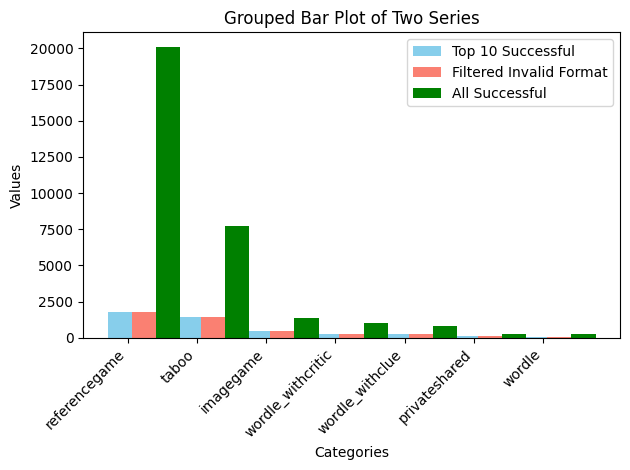

In [16]:
import matplotlib.pyplot as plt
import numpy as np

series1 = data_successful.game.value_counts()
series2 = filtered_successful.game.value_counts()
series3 = data_all_successful.game.value_counts()

# Set the positions and width for the bars
bar_width = 0.35  # Set the width of the bars
index = np.arange(len(series1))  # The label locations

# Create the bar plots for both series
plt.bar(index, series1, bar_width, label='Series 1', color='skyblue')
plt.bar(index + bar_width, series2, bar_width, label='Series 2', color='salmon')
plt.bar(index + 2*bar_width, series3, bar_width, label='Series 3', color='green')

# Adding labels, title, and legend
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Grouped Bar Plot of Two Series')
plt.xticks(index + bar_width / 3, series1.index, rotation=45, ha='right')  # Center x-tick labels
plt.legend(['Top 10 Successful', 'Filtered Invalid Format', 'All Successful',])  # Show legend

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

In [17]:
taboo_data: pd.DataFrame = filtered_successful[filtered_successful.game == 'taboo']
taboo_data.target.value_counts()

target
enclose        40
puppy          22
biology        22
length         22
applicant      22
               ..
designation     4
rental          4
quarterly       4
cameroon        4
statute         2
Name: count, Length: 114, dtype: int64

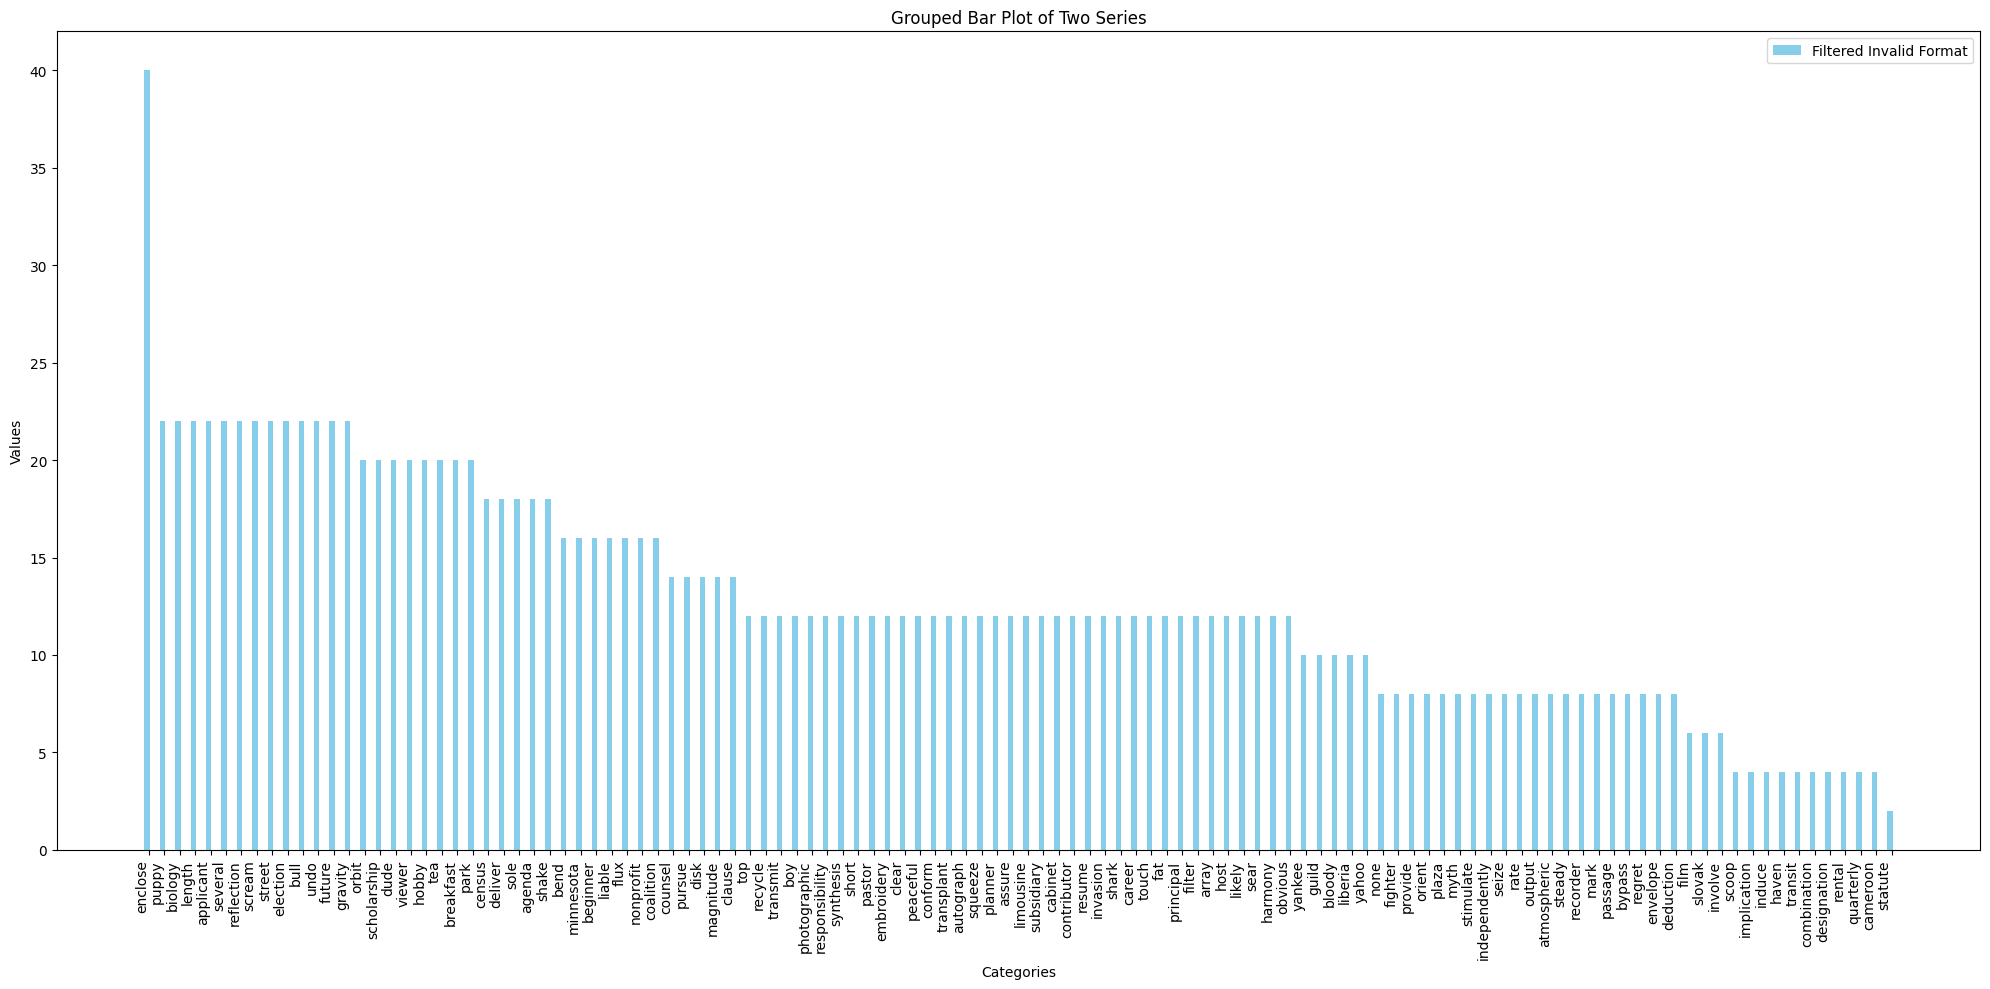

In [18]:
plt.rcParams["figure.figsize"] = (20,10)

series1 = taboo_data.target.value_counts()
# Set the positions and width for the bars
bar_width = 0.35  # Set the width of the bars
index = np.arange(len(series1))  # The label locations


# Create the bar plots for both series
plt.bar(index, series1, bar_width, label='Series 1', color='skyblue')

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Grouped Bar Plot of Two Series')
plt.xticks(index + bar_width / 3, series1.index, rotation=90, ha='right')  # Center x-tick labels
plt.legend(['Filtered Invalid Format'])  # Show legend

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

In [3]:
import os
import pandas as pd

In [2]:
os.listdir('../../data/training_data')

['D10001.csv',
 'D20002.csv',
 'training_data.csv',
 'D20003.csv',
 'D20001.csv',
 'D30004.csv',
 'D30001.csv',
 'D30002.csv',
 'D30003.csv',
 'clem_top_10_models_data_all_successful_episodes_no_preprocessing.csv',
 'clem_top_10_models_data_all_successful_episodes_individual_turns_adapted_imagegame.csv',
 '.ipynb_checkpoints',
 'clem_top_10_models_data_all_successful_episodes_individual_turns.csv']

In [6]:
for model in os.listdir('../../data/training_data'):
    df = pd.read_csv('../../data/training_data/' + model)
    print(model, len(df))

D10001.csv 3794
D20002.csv 912
training_data.csv 3875
D20003.csv 318
D20001.csv 2177
D30004.csv 2908
D30001.csv 9044
D30002.csv 6635
D30003.csv 4122
clem_top_10_models_data_all_successful_episodes_no_preprocessing.csv 2247
clem_top_10_models_data_all_successful_episodes_individual_turns_adapted_imagegame.csv 8001


IsADirectoryError: [Errno 21] Is a directory: '../../data/training_data/.ipynb_checkpoints'